First, establish an ssh tunnel [with your PNI password] to jtb3-dev.princeton.edu to make the database available to you:

    ssh username@jtb3-dev.princeton.edu -L 3306:127.0.0.1:3306 -N

jtb3-dev is the database server on which all behavior and mouse data is stored. Second, make sure you have installed datajoint >= '0.12.dev3'
[ pip install datajoint==0.12.dev3 ]

In [1]:
import pylab as pl
import datajoint as dj
import numpy as np
import os,sys
import secrets
assert dj.__version__>='0.12.dev3'
import pickle
from datetime import datetime
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import pandas as pd

In [2]:
schema = dj.schema('ahoag_lightsheet_demo') 

Please enter DataJoint username: ahoag
Please enter DataJoint password: ········
Connecting ahoag@localhost:3306


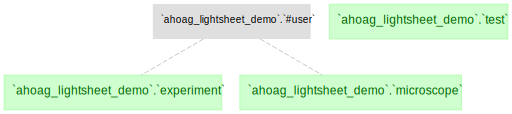

In [3]:
dj.ERD(schema)

In [ ]:
# Reset the schema to blank state by uncommenting the line below
# schema.drop()

## 1) Define database tables

In [4]:
@schema
class User(dj.Lookup):
    definition = """
    # Users of the light sheet microscope
    username : varchar(20)      # user in the lab
    ---
    email       : varchar(50)
    """

@schema
class Experiment(dj.Manual):
    definition = """ # Experiments performed using the light sheet microscope
    experiment_id           :   smallint auto_increment    # allowed here are sql datatypes.
    ----
    -> User 
    title                   :   varchar(100)
    description             :   varchar(250)
    notes = ""              :   varchar(1000)
    species                 :   varchar(50)
    clearing_protocol       :   enum("iDISCO+_immuno","iDISCO abbreviated clearing","uDISCO","iDISCO+","iDISCO_EdU")
    clearing_progress       :   enum("incomplete","complete")
    fluorophores            :   varchar(100)
    primary_antibody        :   varchar(100)
    secondary_antibody      :   varchar(100)
    image_resolution        :   enum("1.3x","4x")
    cell_detection          :   tinyint
    registration            :   tinyint
    probe_detection         :   tinyint
    injection_detection     :   tinyint
    """  
    
@schema #  
class Microscope(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
    definition = """ # Periodic calibration data of the light sheet microscope
    entrynum                :   smallint auto_increment    # allowed here are sql datatypes.
    ----
    -> User              
    date                    :   varchar(10)    
    old_objective           :   varchar(50)
    new_objective           :   varchar(50)
    swapper                 :   varchar(250)
    calibration =           :   varchar(1000) 
    notes =                 :   varchar(1000)
    """

In [ ]:
User()

In [ ]:
Experiment()

In [ ]:
Microscope()

## 2) Download content for the database from existing google sheets and the Sheets API

In [ ]:
# Set the scope to be read only since we are not adding anything to the google sheet, just reading it
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
# Set the spreadsheet ID (long string in the url, e.g.: 
# https://docs.google.com/spreadsheets/d/1YbP64yIApUaxjpscBXP8r82VmrkrKYakbjRFqF9XHB0/edit#gid=0) 
# As well as the range of cells you want to grab. 
SPREADSHEET_ID = '1A83HVyy1bEhctqArwt4EiT637M8wBxTFodobbt1jrXI' # The live clearing/form responses spreadsheet
# We are in readonly (see SCOPES) so we cannot destroy it by accident.
secrets_file = 'credentials.json' # Has to be called "credentials.json"  
assert os.path.exists(secrets_file)

In [ ]:
def retrieve_google_sheet(spreadsheet_id,range_query):
    """
    ---PURPOSE---
    Get data from the range of cells in the google sheet specified.
    ---INPUT---
    spreadsheet_id    The long string in the URL of a google sheet
                      that identifies the sheet
    range_query       The Sheets API range query, e.g. 'Sheet1!A3:B3'
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                secrets_file, SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=spreadsheet_id,
                                range=range_query).execute()
    values = result.get('values', [])

    return values

## Fill User and Experiment tables

In [ ]:
# Grab the form response data so we can fill out User() and Experiment() table
range_query='Form Responses!B4:P36'
form_response_data = retrieve_google_sheet(spreadsheet_id=SPREADSHEET_ID,range_query=range_query)
# Remove "Number of Samples" column since it is empty and we don't want it
form_response_data=[x[0:3]+x[4:] for x in form_response_data]

In [ ]:
def fill_user_exp_tables():
    """ Fills the User() and Experiment() tables 
    using the form response data from the tab in the clearing google spreadsheet
    """
    exp_column_names = ['username','species','clearing_protocol','clearing_progress','title','description','fluorophores',\
                    'primary_antibody','secondary_antibody','image_resolution',\
                    'cell_detection','registration','probe_detection','injection_detection','notes'] # order doesn't matter since we will be using these in a dictionary
    if len(User.fetch()) != 0 or len(Experiment.fetch()) != 0:
        sys.exit('User and/or Experiment table not empty! Drop them first before refilling')

    for form_response in form_response_data:
        # ignore blank lines
        if not form_response:
            continue
        assert len(form_response) == 14
        species = form_response[0].lower()
        clearing_protocol = form_response[1]
        if 'immunostaining' in clearing_protocol:
            clearing_protocol = 'iDISCO+_immuno'
        elif 'abbreviated' in clearing_protocol:
            clearing_protocol = 'iDISCO abbreviated clearing'
        elif 'EdU' in clearing_protocol:
            clearing_protocol = 'iDISCO_EdU'
        else: # don't change it
            pass
        clearing_progress = 'complete' # All of the ones in this sheet have already been completed
        title=form_response[2]
        description = form_response[3]
        fluorophores = form_response[4]
        primary_antibody = form_response[5]
        secondary_antibody = form_response[6]
        imaging_str = form_response[7]
        image_resolution = "1.3x" if "1.3x" in imaging_str else "4x"
        processing_str = form_response[8]
        processing_list = [x.lower() for x in processing_str.split(',')]

        cell_detection = 0
        registration = 0
        probe_detection = 0
        injection_detection = 0
        for item in processing_list:
            if 'cell detection' in item:
                cell_detection = 1
            if 'registration' in item:
                registration=1
            if 'probe' in item and 'detection' in item:
                probe_detection = 1
            if 'injection' in item and 'detection' in item:
                injection_detection =1
        notes = form_response[11]
        email = form_response[13]
        username = email.split('@')[0].lower() if 'princeton' in email else 'zmd' # zahra is the only one who used her gmail
        
        user_insert_dict = {'username':username,'email':email}
        
        exp_insert_row = [username,species,clearing_protocol,clearing_progress,title,description,fluorophores,\
                      primary_antibody,secondary_antibody,image_resolution,cell_detection,registration,\
                      probe_detection,injection_detection,notes]
        exp_insert_dict = {exp_column_names[ii]:exp_insert_row[ii] for ii in range(len(exp_column_names))}
        
        User().insert1(user_insert_dict,skip_duplicates=True)
        Experiment().insert1(exp_insert_dict)

In [ ]:
fill_user_exp_tables()

In [ ]:
User()

In [ ]:
Experiment()

## Fill Microscope Table

In [ ]:
# Only does this if the table does not already exist.
def fill_microscope_table():
    microscope_spreadsheet_id = '1Velwahzvy0hxHDlcjlQPbLjShCQMmCb2DWuz-O_65PI' # The live spreadsheet
    microscope_range_query = 'Sheet1' # Syntax is Sheet_name!cell_start:cell_end, e.g. 
    if len(Microscope.fetch()) != 0:
        sys.exit('Microscope table not empty. Drop it before attempting to refill')
    values = retrieve_google_sheet(spreadsheet_id=microscope_spreadsheet_id,range_query=microscope_range_query)
    microscope_column_names = ['username','date','old_objective','new_objective','swapper','calibration','notes'] # in the database
    for row in values[1:]: # skip the first row because it is the column names
        if len(row) < 2:
            continue
        try:
            date_str = datetime.strptime(row[0], "%B %d, %Y").strftime("%Y-%m-%d")
        except:
            date_str = 'unknown'
        for ii in range(len(microscope_column_names)-len(row)):
            row.append('')
        microscope_insert_row = ['zmd',date_str] + row[1:]    
        microscope_insert_dict = {microscope_column_names[ii]:microscope_insert_row[ii]\
                                  for ii in range(len(microscope_column_names))}
        Microscope().insert1(microscope_insert_dict,skip_duplicates = True)

In [ ]:
fill_microscope_table()

In [ ]:
Microscope()

In [ ]:
dj.ERD(schema)

## Add clearing tables

### iDISCO+ clearing table

In [5]:
@schema
class IdiscoPlusClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
        definition = """ # Periodic calibration data of the light sheet microscope
        -> Experiment              # experiment_id, the primary key from the Experiment() table
        ----
        -> User                    # username, the researcher's netid from the User() table
        clearer                                                  :   varchar(20)   # the netid of the person who did the clearing
        exp_notes = ""                                           :   varchar(500)  # Note anything unusual that happened during experiment that could affect clearing
        perfusion_date = NULL                                    :   date 
        time_dehydr_pbs_wash1 = NULL                             :   datetime
        time_dehydr_pbs_wash2 = NULL                             :   datetime
        time_dehydr_pbs_wash3 = NULL                             :   datetime
        time_dehydr_ch3oh_20percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_40percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_60percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_80percent_wash1 = NULL                 :   datetime
        time_dehydr_ch3oh_100percent_wash1 = NULL                :   datetime
        time_dehydr_ch3oh_100percent_wash2 = NULL                :   datetime
        time_dehydr_h202_wash1 = NULL                            :   datetime
        time_rehydr_ch3oh_100percent_wash1 = NULL                :   datetime
        time_rehydr_ch3oh_80percent_wash1 = NULL                 :   datetime
        time_rehydr_ch3oh_60percent_wash1 = NULL                 :   datetime
        time_rehydr_ch3oh_40percent_wash1 = NULL                 :   datetime
        time_rehydr_ch3oh_20percent_wash1 = NULL                 :   datetime
        time_rehydr_pbs_wash1 = NULL                             :   datetime
        time_rehydr_sodium_azide_wash1 = NULL                    :   datetime
        time_rehydr_sodium_azide_wash2 = NULL                    :   datetime
        time_rehydr_glycine_wash1 = NULL                         :   datetime
        time_blocking_start_roomtemp = NULL                      :   datetime
        time_blocking_donkey_serum = NULL                        :   datetime
        time_antibody1_start_roomtemp = NULL                     :   datetime
        time_antibody1_ptwh_wash1 = NULL                         :   datetime
        time_antibody1_ptwh_wash2 = NULL                         :   datetime
        time_antibody1_added = NULL                              :   datetime
        time_wash1_start_roomtemp = NULL                          :   datetime
        time_wash1_ptwh_wash1 = NULL                              :   datetime
        time_wash1_ptwh_wash2 = NULL                              :   datetime
        time_wash1_ptwh_wash3 = NULL                              :   datetime
        time_wash1_ptwh_wash4 = NULL                              :   datetime
        time_wash1_ptwh_wash5 = NULL                              :   datetime
        time_antibody2_added = NULL                              :   datetime
        time_wash2_start_roomtemp = NULL                          :   datetime
        time_wash2_ptwh_wash1 = NULL                              :   datetime
        time_wash2_ptwh_wash2 = NULL                              :   datetime
        time_wash2_ptwh_wash3 = NULL                              :   datetime
        time_wash2_ptwh_wash4 = NULL                              :   datetime
        time_wash2_ptwh_wash5 = NULL                              :   datetime
        time_clearing_ch3oh_20percent_wash1 = NULL               :   datetime
        time_clearing_ch3oh_40percent_wash1 = NULL               :   datetime
        time_clearing_ch3oh_60percent_wash1 = NULL               :   datetime
        time_clearing_ch3oh_80percent_wash1 = NULL               :   datetime
        time_clearing_ch3oh_100percent_wash1 = NULL              :   datetime
        time_clearing_ch3oh_100percent_wash2 = NULL              :   datetime
        time_clearing_dcm_66percent_ch3oh_33percent = NULL       :   datetime
        time_clearing_dcm_wash1 = NULL                           :   datetime
        time_clearing_dcm_wash2 = NULL                           :   datetime
        time_clearing_dbe = NULL                                 :   datetime
        time_clearing_new_tubes = NULL                           :   datetime
        clearing_notes = ""                                      : varchar(500)
        """

In [ ]:
# @schema
# class IdiscoPlusClearing(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
#         definition = """ # Periodic calibration data of the light sheet microscope
#         -> Experiment              # experiment_id, the primary key from the Experiment() table
#         ----
#         -> User                    # username, the researcher's netid from the User() table
#         clearer                                           :   varchar(20)   # the netid of the person who did the clearing
#         exp_notes = ""                                    :   varchar(200)  # Note anything unusual that happened during experiment that could affect clearing
#         perfusion_date = NULL                             :   date 
#         """

In [8]:
IdiscoPlusClearing()

experiment_id allowed here are sql datatypes.,username user in the lab,clearer the netid of the person who did the clearing,exp_notes Note anything unusual that happened during experiment that could affect clearing,perfusion_date,time_dehydr_pbs_wash1,time_dehydr_pbs_wash2,time_dehydr_pbs_wash3,time_dehydr_ch3oh_20percent_wash1,time_dehydr_ch3oh_40percent_wash1,time_dehydr_ch3oh_60percent_wash1,time_dehydr_ch3oh_80percent_wash1,time_dehydr_ch3oh_100percent_wash1,time_dehydr_ch3oh_100percent_wash2,time_dehydr_h202_wash1,time_rehydr_ch3oh_100percent_wash1,time_rehydr_ch3oh_80percent_wash1,time_rehydr_ch3oh_60percent_wash1,time_rehydr_ch3oh_40percent_wash1,time_rehydr_ch3oh_20percent_wash1,time_rehydr_pbs_wash1,time_rehydr_sodium_azide_wash1,time_rehydr_sodium_azide_wash2,time_rehydr_glycine_wash1,time_blocking_start_roomtemp,time_blocking_donkey_serum,time_antibody1_start_roomtemp,time_antibody1_ptwh_wash1,time_antibody1_ptwh_wash2,time_antibody1_added,time_wash1_start_roomtemp,time_wash1_ptwh_wash1,time_wash1_ptwh_wash2,time_wash1_ptwh_wash3,time_wash1_ptwh_wash4,time_wash1_ptwh_wash5,time_antibody2_added,time_wash2_start_roomtemp,time_wash2_ptwh_wash1,time_wash2_ptwh_wash2,time_wash2_ptwh_wash3,time_wash2_ptwh_wash4,time_wash2_ptwh_wash5,time_clearing_ch3oh_20percent_wash1,time_clearing_ch3oh_40percent_wash1,time_clearing_ch3oh_60percent_wash1,time_clearing_ch3oh_80percent_wash1,time_clearing_ch3oh_100percent_wash1,time_clearing_ch3oh_100percent_wash2,time_clearing_dcm_66percent_ch3oh_33percent,time_clearing_dcm_wash1,time_clearing_dcm_wash2,time_clearing_dbe,time_clearing_new_tubes,clearing_notes
1,jverpeut,ahoag,,None,2019-01-30 14:30:00,2019-01-30 15:00:00,2019-01-30 15:30:00,2019-02-04 09:14:00,2019-02-04 10:04:00,2019-02-04 10:56:00,2019-02-04 11:47:00,2019-02-04 12:41:00,2019-02-04 13:32:00,2019-02-26 16:58:00,2019-02-27 11:01:00,2019-02-27 11:55:00,2019-02-27 12:50:00,2019-02-27 13:43:00,2019-02-27 14:40:00,2019-02-27 15:35:00,2019-02-27 16:32:00,2019-02-27 17:28:00,2019-02-27 18:26:00,2019-03-01 09:54:00,2019-03-01 12:06:00,2019-03-04 09:34:00,2019-03-04 11:33:00,None,2019-03-04 14:58:00,2019-03-11 10:05:00,2019-03-11 12:50:00,2019-03-11 13:15:00,2019-03-11 13:45:00,2019-03-11 14:36:00,2019-03-11 15:42:00,2019-03-12 14:11:00,2019-03-13 10:27:00,2019-03-13 12:48:00,2019-03-13 13:10:00,2019-03-13 13:40:00,2019-03-13 14:23:00,2019-03-13 15:37:00,2019-03-20 10:36:00,2019-03-20 11:13:00,2019-03-20 11:57:00,2019-03-20 13:00:00,2019-03-20 13:55:00,2019-03-20 14:55:00,2019-03-20 15:55:00,2019-03-20 18:55:00,2019-03-20 19:10:00,2019-03-20 19:30:00,2019-03-21 11:40:00,


In [10]:
IdiscoPlusClearing().fetch1()

{'experiment_id': 1,
 'username': 'jverpeut',
 'clearer': 'ahoag',
 'exp_notes': '',
 'perfusion_date': None,
 'time_dehydr_pbs_wash1': datetime.datetime(2019, 1, 30, 14, 30),
 'time_dehydr_pbs_wash2': datetime.datetime(2019, 1, 30, 15, 0),
 'time_dehydr_pbs_wash3': datetime.datetime(2019, 1, 30, 15, 30),
 'time_dehydr_ch3oh_20percent_wash1': datetime.datetime(2019, 2, 4, 9, 14),
 'time_dehydr_ch3oh_40percent_wash1': datetime.datetime(2019, 2, 4, 10, 4),
 'time_dehydr_ch3oh_60percent_wash1': datetime.datetime(2019, 2, 4, 10, 56),
 'time_dehydr_ch3oh_80percent_wash1': datetime.datetime(2019, 2, 4, 11, 47),
 'time_dehydr_ch3oh_100percent_wash1': datetime.datetime(2019, 2, 4, 12, 41),
 'time_dehydr_ch3oh_100percent_wash2': datetime.datetime(2019, 2, 4, 13, 32),
 'time_dehydr_h202_wash1': datetime.datetime(2019, 2, 26, 16, 58),
 'time_rehydr_ch3oh_100percent_wash1': datetime.datetime(2019, 2, 27, 11, 1),
 'time_rehydr_ch3oh_80percent_wash1': datetime.datetime(2019, 2, 27, 11, 55),
 'time_r

In [ ]:
val=(IdiscoPlusClearing() & 'experiment_id=1').fetch1('time_dehydr_pbs_wash1')

In [ ]:
dj.__version__

In [ ]:
(IdiscoPlusClearing() & 'experiment_id=1').fetch1()

In [ ]:
Id

In [ ]:
dj.__version__

In [ ]:
dj.ERD(schema)

In [ ]:
s = '4 PM'
datetime.strptime(s, "%I %p")

In [ ]:
clearing_SPREADSHEET_ID = '1iy4H8kHocnu9sS9P-NZA8qcp6_R4gj0ogwksl3I-suU' # the copy I have been editing
clearing_range_query = 'iDISCO+!A6:BE15' # Syntax is Sheet_name!cell_start:cell_end, e.g. 

In [ ]:
iDISCOplus_response_data = retrieve_google_sheet(spreadsheet_id=clearing_SPREADSHEET_ID,range_query=clearing_range_query)

In [ ]:
iDISCOplus_response_data[0]

In [ ]:
@schema
class Test(dj.Manual): # dj.Manual is one of the 4 datajoint table types - Manual corresponds to externally inputted data
        definition = """ # Test table to try out NULL values
        num                           : smallint
        ----
        val = NULL                    : varchar(20)
        date = NULL                   : date 
        """

In [ ]:
Test().insert1({'num':1,'val':'test1','date':'2019-09-26'})
Test().insert1({'num':2,'val':'test2','date':'2019-09-27'})
Test()

In [ ]:
dj.Table._update(Test() & 'num = 2', 'val', 'updated')
Test()

In [ ]:
mydict={'num':1,'val':'test1','date':'2019-09-26'}

In [ ]:
s='time_blocking_donkey_serum_submit'
s.rstrip('_submit')

In [ ]:
s.split('_submit')